In [43]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
import string

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm



In [30]:
# Read Data
with open("news_text.txt", "r", encoding="utf-8") as file:
    # Read the string to the file
    text = file.read()

# print(text)

In [31]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

# create a spaCy object 
doc = nlp(text)

In [33]:
# print token, dependency, POS tag 

# for tok in doc: 
#   print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

In [34]:
# Step 3: Extracting subject, object, and relationship from each sentence
edges = []
punctuations = string.punctuation  # Define the punctuation symbols to be removed

# print(punctuations)

In [35]:
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords

# Download the stop words corpus if it hasn't been downloaded before from nltk library
nltk.download('stopwords')

# Get the English stop words from spacy
nltk_stop_words = set(stopwords.words('english'))

# Print the stop words
print(len(nltk_stop_words))

spacy_stop_words = STOP_WORDS
print(len(spacy_stop_words))

stop_words = []

# Combine the stop words
combined_stop_words = nltk_stop_words.union(spacy_stop_words)

# Print combined stop_words
# print(type(combined_stop_words))
# print(len(combined_stop_words))
# print(combined_stop_words)

179
326


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FCT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
from spacy import displacy

count = 0

def extract_entities(text):
    global count  # Declare count as a global variable
    count += 1

    for sent in doc.sents:
#         displacy.render(sent, style="dep", jupyter=True)
        
        for token in sent:
            token_text = purify_tokens(token.text)  # Call function for purifying token text
            
            
            if token_text.lower() not in combined_stop_words and token_text not in punctuations:        
                if token.dep_ == "nsubj" and token.head.pos_ == "VERB":
                    subject = token_text
                    for child in token.children:
                        if child.dep_ == "amod":
                            subject = child.text + " " + subject
                    for child in token.head.children:
                        if child.dep_ == "dobj":
                            obj = child.text
                            for grandchild in child.children:
                                if grandchild.dep_ == "amod":
                                    obj = grandchild.text + " " + obj
                            edges.append((subject, obj, token.head.text))

    print(count)                        
    print(len(edges))
    
    return edges

# Function to purify each individual token
def purify_tokens(word):
    purified_word = ''
    for char in word:
        if char.lower() not in punctuations:
            purified_word += char
    return purified_word

# purify_tokens('hello: ,i am sujan;')


In [37]:
# Call extract_entities function
extract_entities(text)

1
765


[('system', 'revolution', 'needs'),
 ('majority', 'process', 'undertaking'),
 ('working parents', 'hard time', 'have'),
 ('sector', 'digital revolution', 'awaits'),
 ('team', 'Veda', 'introduced'),
 ('students', 'time', 'save'),
 ('parents', 'easier way', 'have'),
 ('Veda', 'customisable features', 'includes'),
 ('platform', 'it', 'abridged'),
 ('schools', 'that', 'using'),
 ('Nepali companies', 'themselves', 'limited'),
 ('institution', 'that', 'need'),
 ('Veda', 'systems', 'brought'),
 ('team', 'realisation', 'took'),
 ('Nepal', 'that', 'saw'),
 ('Veda', 'presence', 'made'),
 ('foreign schools', 'us', 'approached'),
 ('schools', 'referrals', 'give'),
 ('schools', 'platform', 'acknowledge'),
 ('Dahal', 'Council', 'expanding'),
 ('Yadav', 'charge', 'took'),
 ('Chaudhary', 'responsibility', 'got'),
 ('UML', 'government', 'left'),
 ('Dahal', 'ministry', 'took'),
 ('Yadav', 'leadership', 'took'),
 ('Acharya', 'leadership', 'took'),
 ('changes', 'Ministry', 'weakened'),
 ('facts', 'stateme

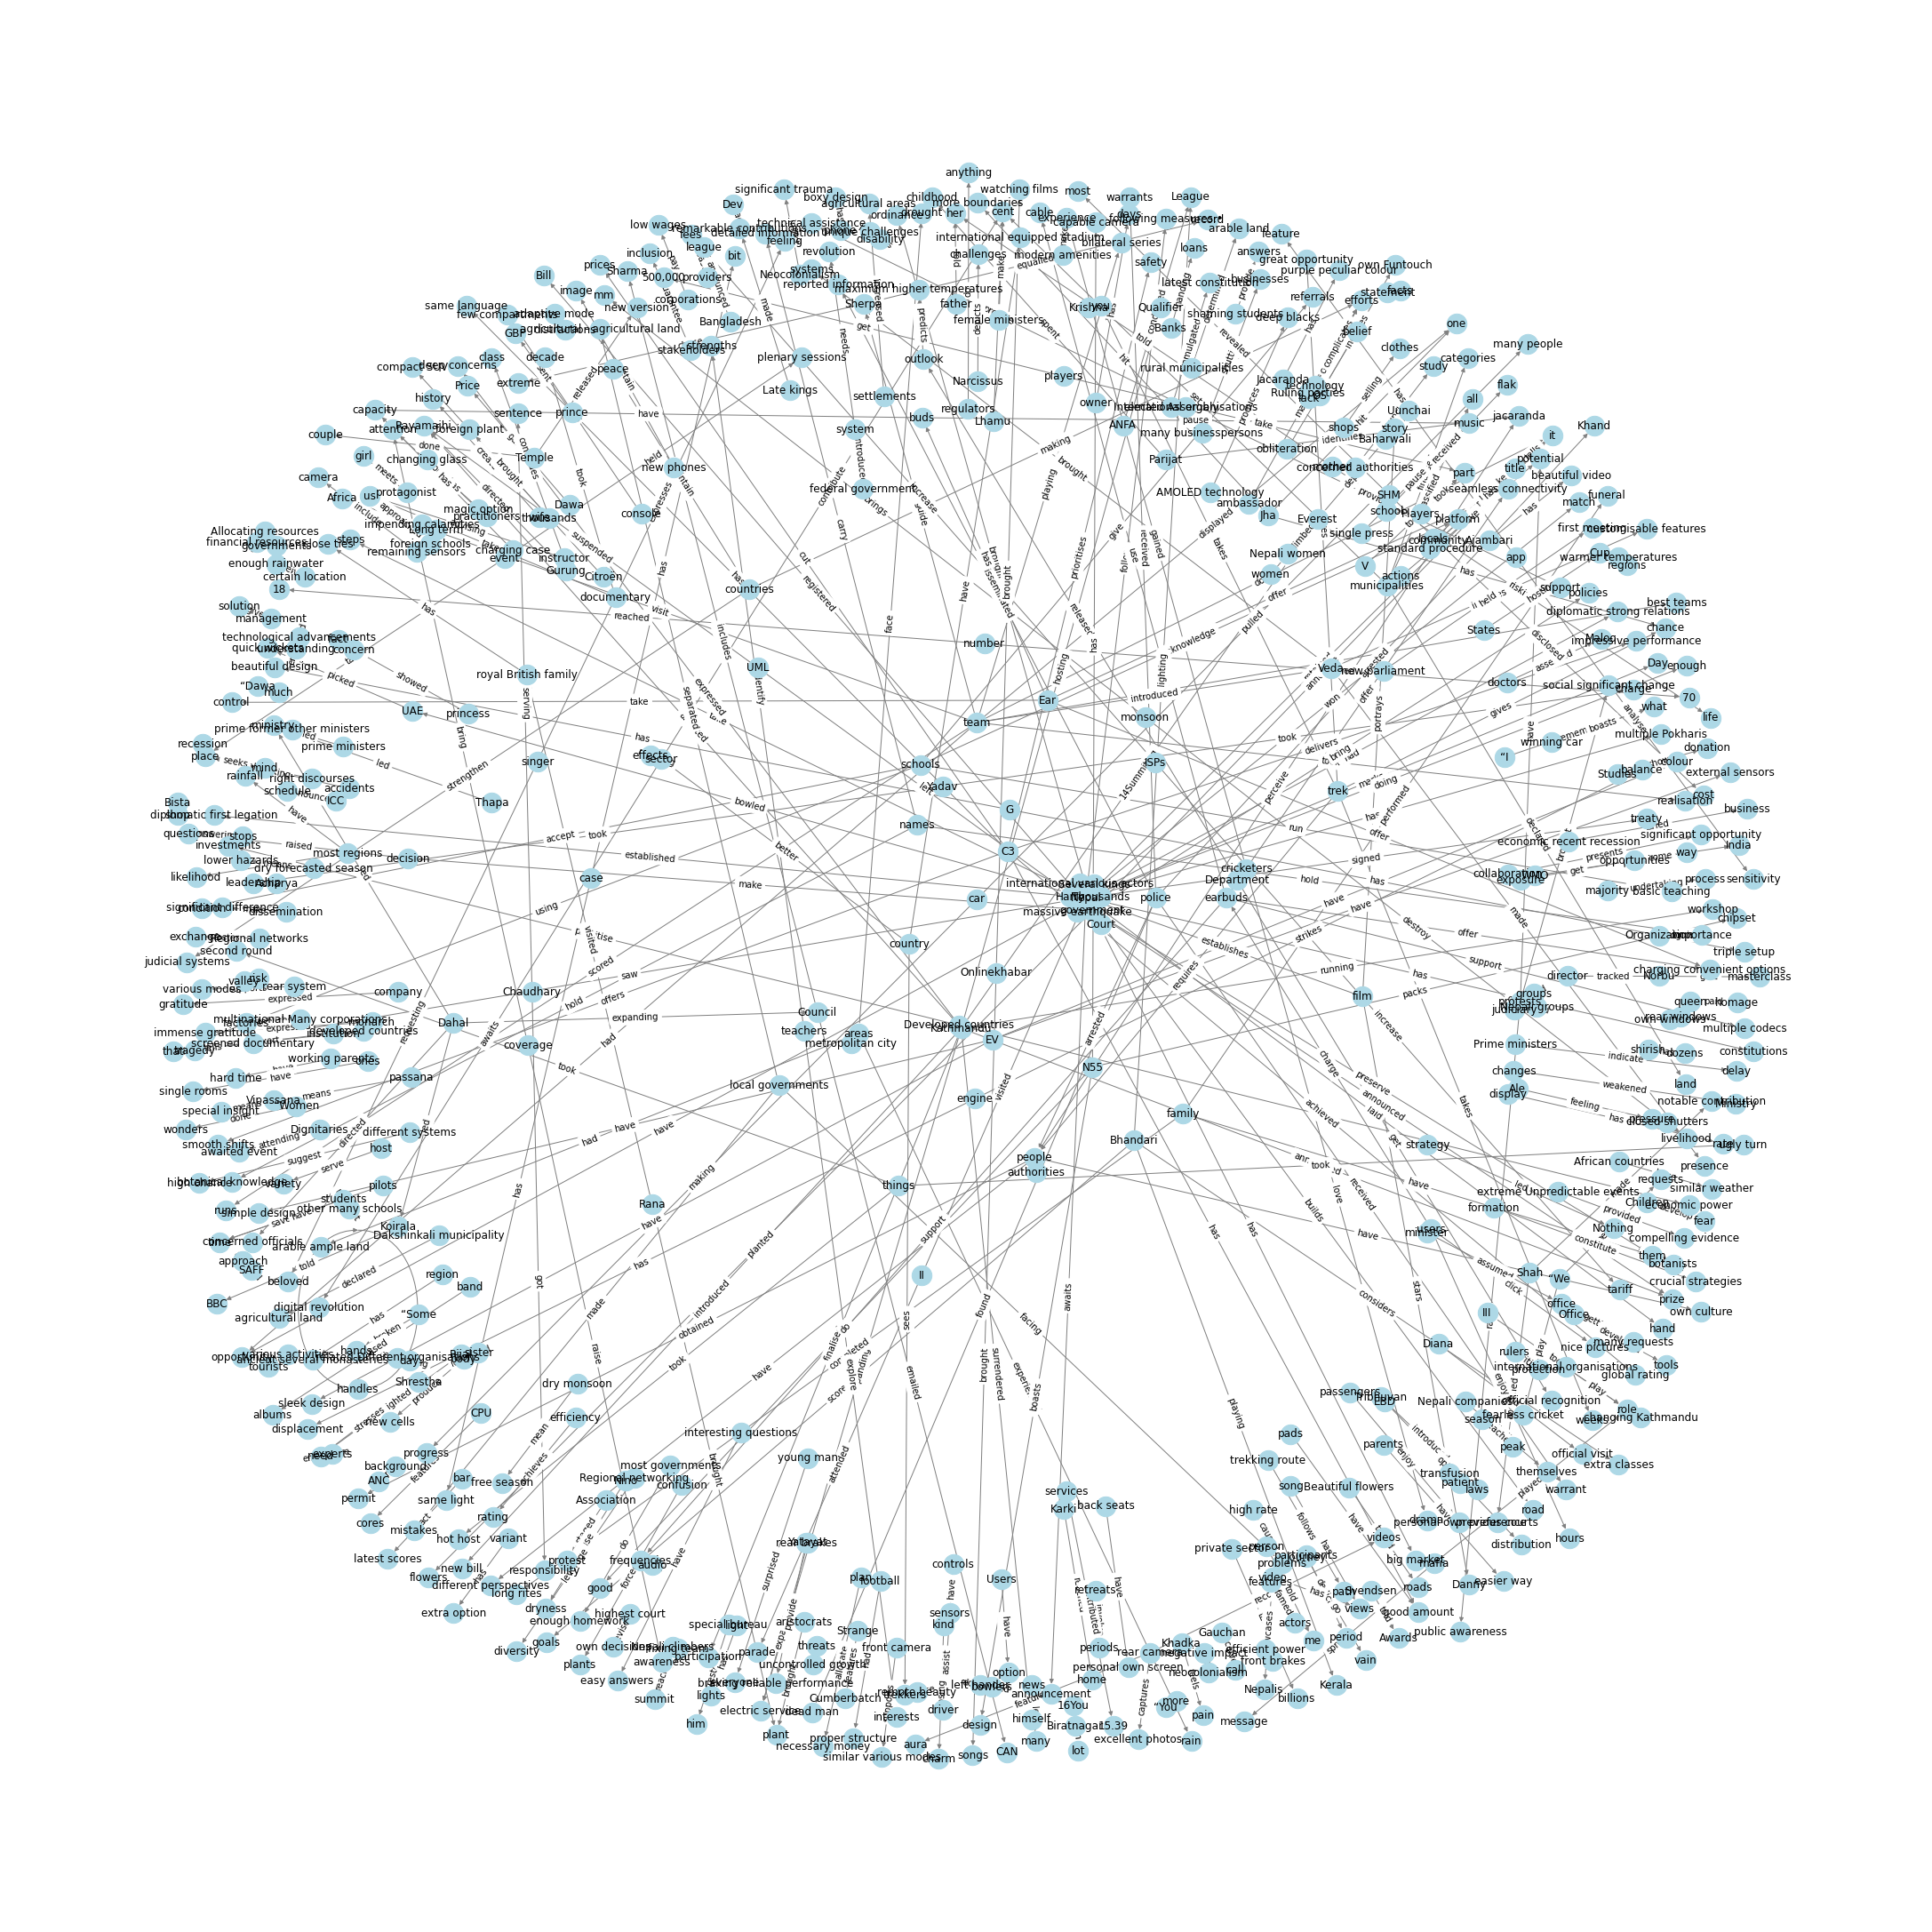

In [38]:
# Step 4: Building a directed graph from the above data
graph = nx.DiGraph()
for edge in edges:
    graph.add_edge(edge[0], edge[1], relation=edge[2])

# Visualize the graph
plt.figure(figsize=(30, 30))
pos = nx.spring_layout(graph)  # Layout algorithm for node positioning
nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True, node_size=500)
edge_labels = nx.get_edge_attributes(graph, 'relation')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.show()


# Save the graph as a GraphML file
nx.write_graphml(graph, "knowledge_graph.graphml")


In [41]:
# Step 5: Get an answer to the given question. Question sentences should be in natural language, follow the necessary steps to get the answer from the graph db.


def question_answer_about_relation(keywords):    
    # Step 1: Load the graph database
    graph = nx.read_graphml("knowledge_graph.graphml")

    # Step 2: Parse the question and extract relevant keywords or entities
    question = "What is the relationship between X and Y?"
    # Step 3: Query the graph database to retrieve relevant information
    answer = ""
    for keyword in keywords:
        if keyword in graph:
            neighbors = list(graph.neighbors(keyword))
            if neighbors:
                answer += f"{keyword} is related to "
                answer += ", ".join(neighbors)
                answer += ". \n"

    # Step 4: Extract the answer from the retrieved information
    if answer:
        answer = answer.strip()
    else:
        answer = "No information found for the given keywords."

    # Step 5: Display or return the answer
    print(answer)

keywords = ["Prachanda", "minister"]  # keywords extracted from the question
question_answer_about_relation(keywords)


minister is related to office.


In [42]:
def who_question_answer(key):
    # Step 1: load the graph database
    graph = nx.read_graphml("knowledge_graph.graphml")
    
    # Step 2: Parse the question and extract relevant keywords or entities
    question = "Who is X?"
    
    # Step 3: Query the graph database to retrieve relevant information
    answer = ""
    
    if key in graph:
        neighbors = list(graph.neighbors(key))
        if neighbors:
            answer += f"{key} is related to : "
            answer += ", ".join(neighbors)
    
    # Step 4: Extract the answer from the retrieved information
    if answer:
        answer = answer.strip()
    else:
        answer = "No information found for the given keywords."

    # Step 5: Display or return the answer
    print(answer)

key = "Nepal"
who_question_answer(key)

Nepal is related to : that, following measures:•, steps, announcement, big market, multiple Pokharis, Day, constitutions, diplomatic strong relations, treaty, diplomatic first legation, enough, UAE, hand, match, opportunity, it
